In [1]:
import fe
import load_data
import nn_models
import lossPloter as lp

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

import os
import math
import cv2
import random

load catchmant names

In [2]:
patches_root = "test_topo/numpysave"

seed = 1
propotion = 3

patch_size = 128

channels = 1
patch_shape = (patch_size,patch_size,channels + 1)
fortran_order = True

patches_files = [os.path.join(patches_root,f) for f in os.listdir(patches_root)]

random.seed(seed)
random.shuffle(patches_files)

patches_files_train = patches_files[len(patches_files)//propotion:]
patches_files_test = patches_files[:len(patches_files)//propotion]

print(len(patches_files_train),len(patches_files_test))

4896 2447


build the CNN model

In [3]:
nnmodel = nn_models.segnet_256_k7_2(channels, 1,img_size=patch_size)

kernel [7, 7] in_channel 1 out_channel 32
	 Tensor("encode-0_c_0:0", shape=(?, 128, 128, 32), dtype=float32)
	 Tensor("encode-0_c_1:0", shape=(?, 128, 128, 32), dtype=float32)
	 Tensor("encode-0:0", shape=(?, 64, 64, 32), dtype=float32)
kernel [7, 7] in_channel 32 out_channel 64
	 Tensor("encode-1_c_0:0", shape=(?, 64, 64, 64), dtype=float32)
	 Tensor("encode-1_c_1:0", shape=(?, 64, 64, 64), dtype=float32)
	 Tensor("encode-1:0", shape=(?, 32, 32, 64), dtype=float32)
kernel [7, 7] in_channel 64 out_channel 128
	 Tensor("encode-2_c_0:0", shape=(?, 32, 32, 128), dtype=float32)
	 Tensor("encode-2_c_1:0", shape=(?, 32, 32, 128), dtype=float32)
	 Tensor("encode-2:0", shape=(?, 16, 16, 128), dtype=float32)
kernel [7, 7] in_channel 128 out_channel 128
	 Tensor("encode-3_c_0:0", shape=(?, 16, 16, 128), dtype=float32)
	 Tensor("encode-3_c_1:0", shape=(?, 16, 16, 128), dtype=float32)
	 Tensor("encode-3:0", shape=(?, 8, 8, 128), dtype=float32)
kernel [7, 7] in_channel 128 out_channel 128
output sh

generate patches from files

note that:

1. this must be done using the same graph where CNN is constructed, therefore the code is placed after nnmodel

2. be very careful with fortran_order, it affect the results

In [4]:
# (Ellipsis, 0) means if all channels is 0
patch_train = load_data.PatchFromFile(patches_files_train, patch_shape, tf.float32, fortran_order=fortran_order, batch_size=8, shuffle=1000)
patch_test = load_data.PatchFromFile(patches_files_test, patch_shape, tf.float32, fortran_order=fortran_order, batch_size=8, shuffle=1000)

loss and training operations

In [4]:
LR = 0.0002

nnmodel.phs["y"] = tf.placeholder(tf.float32,(None,patch_size,patch_size),name="y")
nnmodel.ls["loss"] = tf.reduce_mean(tf.square(nnmodel.phs["y"] - nnmodel.ls["prediction"]),name="loss")
train_op = tf.train.AdamOptimizer(LR).minimize(nnmodel.ls["loss"])
loss_op = nnmodel.ls["loss"]

In [5]:
model_path = "trained_models"
model_name = nnmodel.name + "-" + "test_topo"

test_folder = "test_folder_" + model_name

print("model", model_name, "will be tested in folder", test_folder)

# make the test folder
if not os.path.exists(test_folder):
    os.mkdir(test_folder)

model segnet_kernel7_2-test_topo will be tested in folder test_folder_segnet_kernel7_2-test_topo


start session

In [6]:
sess = tf.Session()
tf.global_variables_initializer().run(session=sess)
saver = tf.train.Saver()

start training

In [8]:
last_epoch = 0
model_id = "/-" + str(last_epoch-1)

epoch = 40
save_freq = 10

phs = nnmodel.phs

# loss calculator
train_loss = lp.Epoch_Loss()
test_loss = lp.Epoch_Loss()

%matplotlib qt
ploter = lp.Loss_Ploter()

# recover the loss record
if last_epoch > 0:
    print("restoring")
    ploter.load_record(model_path, model_name)
    saver.restore(sess,os.path.join(model_path,model_name+model_id))

print("training")

patch_train.set_session(sess)
patch_test.set_session(sess)

debug = True

for e in range(epoch):
    test_loss.clear()
    train_loss.clear()

    # 1. training
    while not patch_train.end_of_epoch():
        
        xy=patch_train.next_batch()
        
        # debug
        if debug:
            plt.figure(figsize=(12,6))
            plt.subplot(1,2,1)
            plt.imshow(xy[0,:,:,0],vmin=0,vmax=1)
            plt.subplot(1,2,2)
            plt.imshow(xy[0,:,:,-1],vmin=0,vmax=1)
            plt.savefig("debug.png")
            plt.close()
            
            debug=False
        
        if channels > 1:
            _, loss_val = sess.run([train_op,loss_op], feed_dict={phs["x"]:xy[:,:,:,:-1], phs["y"]:xy[:,:,:,-1]})
        else:
            _, loss_val = sess.run([train_op,loss_op], feed_dict={phs["x"]:xy[:,:,:,0], phs["y"]:xy[:,:,:,-1]})
            
        # record batch loss
        train_loss.put_batch(loss_val)
        ploter.put_batch_loss(loss_val)

        # display batch loss curve
        if (ploter.count % 6==5):
            ploter.plot()

    # 2. testing
    while not patch_test.end_of_epoch():
        xy=patch_test.next_batch()
        if channels > 1:
            loss_val = sess.run(loss_op, feed_dict={phs["x"]:xy[:,:,:,:-1], phs["y"]:xy[:,:,:,-1]})
        else:
            loss_val = sess.run(loss_op, feed_dict={phs["x"]:xy[:,:,:,0], phs["y"]:xy[:,:,:,-1]})
            
        test_loss.put_batch(loss_val)

    ploter.put_epoch_loss(train_loss.get_epoch_loss(), test_loss.get_epoch_loss())
    print("epoch",e + last_epoch, "train_loss",train_loss.get_epoch_loss(),"test_loss",test_loss.get_epoch_loss())
    ploter.plot()
    ploter.savefig("training_plot.png")

    if e % save_freq == save_freq-1:
        saver.save(sess, os.path.join(model_path, model_name+"/"),e + last_epoch)
        ploter.save_record(model_path, model_name)

ploter.close()
%matplotlib inline

training
epoch 0 train_loss 0.056762718485997 test_loss 0.05048177335898276
epoch 1 train_loss 0.04330683366267705 test_loss 0.03769178269735349
epoch 2 train_loss 0.03604618183967164 test_loss 0.03539321742635342
epoch 3 train_loss 0.03266479863687814 test_loss 0.03245841345926321
epoch 4 train_loss 0.030655489259040335 test_loss 0.030456330152411087
epoch 5 train_loss 0.029021839810584007 test_loss 0.030901489870659278
epoch 6 train_loss 0.02779606595069316 test_loss 0.028589859750925328
epoch 7 train_loss 0.0266024280625572 test_loss 0.027850266892974283
epoch 8 train_loss 0.025582977597985196 test_loss 0.028003193127612274
epoch 9 train_loss 0.02467096725545726 test_loss 0.02725067304666428
epoch 10 train_loss 0.02367552944452934 test_loss 0.026695137580223623
epoch 11 train_loss 0.022856390459030818 test_loss 0.026393504429827717
epoch 12 train_loss 0.022080127321780215 test_loss 0.026120493142847336
epoch 13 train_loss 0.02147386244230362 test_loss 0.02603126044866014
epoch 14 tr

KeyboardInterrupt: 

testing

In [7]:
def savepng(filename, img_array):
    cv2.imwrite(filename,cv2.cvtColor(img_array,cv2.COLOR_RGBA2BGRA))

def render(nd_array, cmap, vmin=0, vmax = 1, mask_indice=None):
    nd_array = (cmap((nd_array - vmin) / (vmax - vmin))*255).astype(np.uint8)
    if mask_indice is not None:
        nd_array[mask_indice] *= 0
    return nd_array

def run_test_in_session(model, sess, patch_array, channel_num):
    ls = model.ls
    phs = model.phs
    
    patch_array = np.array([patch_array])
    
    if channel_num > 1:
        result = sess.run(ls["prediction"], feed_dict={phs["x"]:patch_array[:,:,:,:-1]})
    else:
        result = sess.run(ls["prediction"], feed_dict={phs["x"]:patch_array[:,:,:,0]})
    
    if len(result)==1:
        return result[0]
    else:
        return result

In [9]:
%matplotlib inline

last_epoch = 20
model_id = "/-" + str(last_epoch-1)

print("restoring")
saver.restore(sess,os.path.join(model_path,model_name+model_id))
# tf.global_variables_initializer().run(session=sess)

print("testing")

for i in range(50):
    nd_image = np.load(patches_files_train[i])
    result = run_test_in_session(nnmodel, sess, nd_image, channels)
    
    plt.figure(figsize=(6,18))
    plt.subplot(3,1,1)
    #plt.title("Input")
    plt.imshow(nd_image[:,:,0].T,cmap="gray",vmin=0,vmax=1)
    plt.subplot(3,1,2)
    #plt.title("Optimized")
    plt.imshow(nd_image[:,:,-1].T,cmap="gray",vmin=0,vmax=1)
    plt.subplot(3,1,3)
    #plt.title("Synthesized")
    plt.imshow(result.T,cmap="gray",vmin=0,vmax=1)
    plt.savefig(os.path.join(test_folder,"train_"+str(i)+".png"), dpi=300)
    plt.close()

for i in range(50):
    nd_image = np.load(patches_files_test[i])
    result = run_test_in_session(nnmodel, sess, nd_image, channels)
    
    plt.figure(figsize=(6,18))
    plt.subplot(3,1,1)
    #plt.title("Input")
    plt.imshow(nd_image[:,:,0].T,cmap="gray",vmin=0,vmax=1)
    plt.subplot(3,1,2)
    #plt.title("Optimized")
    plt.imshow(nd_image[:,:,-1].T,cmap="gray",vmin=0,vmax=1)
    plt.subplot(3,1,3)
    #plt.title("Synthesized")
    plt.imshow(result.T,cmap="gray",vmin=0,vmax=1)
    plt.savefig(os.path.join(test_folder,"test_"+str(i)+".png"), dpi=300)
    plt.close()

restoring
INFO:tensorflow:Restoring parameters from trained_models\segnet_kernel7_2-test_topo/-19
testing


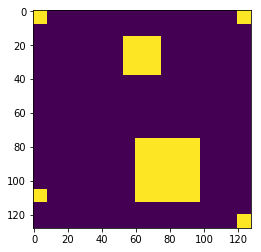

In [48]:
nd_image = np.load(patches_files_train[35])

plt.imshow(nd_image[:,:,0])

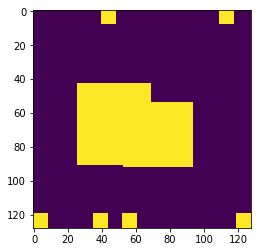

In [13]:
nd_image = np.load(os.path.join(patches_root,files[1970]))

plt.imshow(nd_image[:,:].T)

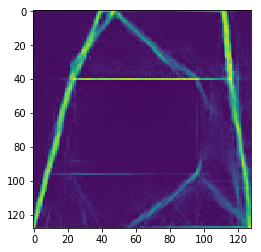

In [14]:
nd_image = np.load(os.path.join(result_root,files[1970]))

plt.imshow(nd_image[:,:].T)

In [8]:
patches_root = "C:\\Users\\guo zifeng\\Desktop\\topologyOpt\\inputs"
files = os.listdir(patches_root)

result_root = "C:\\Users\\guo zifeng\\Desktop\\topologyOpt\\outputs"

In [11]:
last_epoch = 20
model_id = "/-" + str(last_epoch-1)

print("restoring")
saver.restore(sess,os.path.join(model_path,model_name+model_id))
# tf.global_variables_initializer().run(session=sess)

for f in files:
    nd_image = np.load(os.path.join(patches_root,f))[...,None]
    result = run_test_in_session(nnmodel, sess, nd_image, channels)
    np.save(os.path.join(result_root,f), result)

restoring
INFO:tensorflow:Restoring parameters from trained_models\segnet_kernel7_2-test_topo/-19


In [16]:
files[1970]

'2772.npy'